### Medical Analyst With Human Loop

There are typically three different actions that you can do with a human-in-the-loop workflow:

Approve or Reject: Pause the graph before a critical step, such as an API call, to review and approve the action. If the action is rejected, you can prevent the graph from executing the step, and potentially take an alternative action. This pattern often involve routing the graph based on the human's input.

Edit Graph State: Pause the graph to review and edit the graph state. This is useful for correcting mistakes or updating the state with additional information. This pattern often involves updating the state with the human's input.

Get Input: Explicitly request human input at a particular step in the graph. This is useful for collecting additional information or context to inform the agent's decision-making process or for supporting multi-turn conversations.



In [1]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_openai import ChatOpenAI


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")


llm=ChatOpenAI(model="gpt-4o")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BRGA6Eh0rqJL6iNsd1VICnKtJAlbl', 'finish_reason': 'stop', 'logprobs': None}, id='run-984e8e9e-072c-45cd-b735-317f20ccaaa4-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [2]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel,Field

class MedicalAnalyst(BaseModel):
    affiliation:str=Field(
        description="Primary qualification of the medical anaylyst"
    )
    name:str=Field(
        description="Name of the Medical Analyst "
    )
    role:str=Field(
        description="Role of the medical analyst in the context of the research topic",
    )
    description:str=Field(
        description="Description of the medical analyst research focus,concerns and research objectives to achieve"
    )
    @property
    def persona(self)->str:
        return f" Name:{self.name} \n Role:{self.role} \n affiliation:{self.affiliation}\n Description:{self.description}\n"


class Perspectives(BaseModel):
    medicalanalysts:List[MedicalAnalyst]=Field(
        description="Comprehensive list of medical analyst with there roles and affiliations "
    )

class GenerateMedicalAnalystState(TypedDict):
    researchTopic:str # Research topic
    max_medical_analysts:int # number of analysts
    human_analyst_feedback:str # human feedback
    medicalanalysts:List[MedicalAnalyst] #Medical analyst asking questions


In [3]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

medical_analyst_instructions="""You are tasked with creating a set of Medical AI analyst personas. Follow these instructions carefully:

1. First, review the medical research topic:
{researchTopic}
        
2. Examine any medical editorial feedback or medical research   that has been optionally provided to guide creation of the medical analysts that will work to generate medicines for the research or you can your own knowledge for this task: 
        
{human_analyst_feedback}
    
3. Determine the most interesting research parts based upon documents and / or feedback above.
                    
4. Pick the top {max_medical_analysts} research.

5. Assign one analyst to each research part."""

In [4]:
def  create_medical_analysts(state:GenerateMedicalAnalystState):
    """Create medical analysts"""

    researchTopic=state["researchTopic"]
    max_medical_analysts=state["max_medical_analysts"]
    human_analyst_feedback=state.get('human_analyst_feedback')

    #Enforece structured output
    structured_llm=llm.with_structured_output(Perspectives)

    #System message
    system_message=medical_analyst_instructions.format(researchTopic=researchTopic,
                                                       human_analyst_feedback=human_analyst_feedback,
                                                       max_medical_analysts=max_medical_analysts)
    
    #Generate questions

    analysts=structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of medical analyst")])

    #Write the list of analysis to state
    return {"medicalanalysts":analysts.medicalanalysts}


In [5]:
def human_feedback(state:GenerateMedicalAnalystState):
    """No operation node that should be interrupted"""
    pass

In [6]:
def should_continue(state:GenerateMedicalAnalystState):
    """Return the next node to execute"""

    #check if human feedback

    human_analyst_feedback=state.get("human_analyst_feedback",None)
    if( human_analyst_feedback):
        return "create_medical_analysts"
    return END


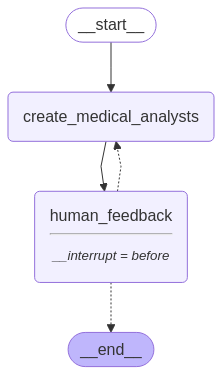

In [7]:
#Add nodes and edges 

medical_analyst_builder=StateGraph(GenerateMedicalAnalystState)

medical_analyst_builder.add_node("create_medical_analysts",create_medical_analysts)
medical_analyst_builder.add_node("human_feedback",human_feedback)
medical_analyst_builder.add_edge(START,"create_medical_analysts")
medical_analyst_builder.add_edge("create_medical_analysts","human_feedback")
medical_analyst_builder.add_conditional_edges("human_feedback",should_continue,["create_medical_analysts",END])
#compile

memory=MemorySaver()
graph=medical_analyst_builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

#View
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# Input
max_medical_analysts=4
topic="Vaccines for  chicken pox diseaes"
thread={"configurable":{"thread_id":"1"}}


In [12]:
# Run the graph until the first interruption
for event in graph.stream({"researchTopic":topic,"max_medical_analysts":max_medical_analysts},thread,stream_mode="values"):
     analysts=event.get("medicalanalysts",'')
     if analysts:
          for analyst in analysts:
               print(f"Name :{analyst.name}")
               print(f"Affiliation:{analyst.affiliation}" )
               print(f"Role:{analyst.role}")
               print(f"Description:{analyst.description}")
               print("-"*50)

Name :Dr. Eleanor Morgan
Affiliation:Virology Department, Johns Hopkins University
Role:Virologist
Description:Dr. Eleanor Morgan focuses on the genetic composition of the Varicella Zoster virus and its implications on vaccine development. She aims to identify key viral epitopes that are most likely to elicit strong immune responses, thereby improving the efficacy of new vaccines against chicken pox. Her research also concerns potential mutations that could impact future vaccine effectiveness.
--------------------------------------------------
Name :Dr. Rahul Desai
Affiliation:Immunology Institute, Stanford University
Role:Immunologist
Description:Dr. Rahul Desai investigates how the immune system interacts with the chicken pox virus post-vaccination. His main objective is to enhance the understanding of long-term immunity and the potential need for booster doses in the chicken pox vaccination schedule. He is particularly concerned with the durability of the immune memory response in d

In [ ]:
state=graph.get_state(thread)


In [14]:
state.next

('human_feedback',)

In [15]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a research for children chicken pox"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f024257-df3b-6f34-8004-d6b7e6d2d1ad'}}

In [17]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('medicalanalysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Alice Thompson
Affiliation: Pediatric Vaccinology
Role: Lead Pediatric Vaccine Researcher
Description: Dr. Thompson focuses on the development and optimization of chicken pox vaccines specifically tailored for children. Her primary concerns involve ensuring the safety and efficacy of the vaccine in pediatric populations while minimizing side effects.
--------------------------------------------------
Name: Dr. Robert Chen
Affiliation: Immunology and Vaccine Development
Role: Immunologist
Description: Dr. Chen is responsible for understanding the immune response mechanisms to chicken pox vaccines. His objective is to enhance the vaccine's ability to elicit a robust and lasting immunity against the virus, potentially leading to new vaccine formulations.
--------------------------------------------------
Name: Dr. Emily Watson
Affiliation: Clinical Trials Design
Role: Clinical Trials Specialist
Description: Dr. Watson designs and oversees clinical trials to test new versions of 

In [18]:
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f024260-6b6c-66cc-8008-dd10ac234ba1'}}

In [19]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [20]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('medicalanalysts')

In [23]:
analysts

[MedicalAnalyst(affiliation='Virology and Immunology Research Institute', name='Dr. Eliza Sanders', role='Lead Virologist', description='Dr. Eliza Sanders focuses on the molecular dynamics of the varicella-zoster virus (VZV) that causes chicken pox, aiming to understand how the virus operates in the host and how it can be effectively targeted by vaccines. Her primary concern is to identify any potential genetic variations of VZV that could influence vaccine efficacy.'),
 MedicalAnalyst(affiliation="Pediatric Infectious Disease Department, Children's Hospital", name='Dr. Miguel Rodriguez', role='Pediatric Research Specialist', description="Dr. Miguel Rodriguez is focused on the development of chicken pox vaccines specifically for children. His research involves understanding how children's immune systems react differently to vaccines and designing vaccine schedules that provide robust protection during early childhood without adverse effects."),
 MedicalAnalyst(affiliation='Immunogeneti

In [21]:
final_state.next

()

In [22]:
analysts

[MedicalAnalyst(affiliation='Virology and Immunology Research Institute', name='Dr. Eliza Sanders', role='Lead Virologist', description='Dr. Eliza Sanders focuses on the molecular dynamics of the varicella-zoster virus (VZV) that causes chicken pox, aiming to understand how the virus operates in the host and how it can be effectively targeted by vaccines. Her primary concern is to identify any potential genetic variations of VZV that could influence vaccine efficacy.'),
 MedicalAnalyst(affiliation="Pediatric Infectious Disease Department, Children's Hospital", name='Dr. Miguel Rodriguez', role='Pediatric Research Specialist', description="Dr. Miguel Rodriguez is focused on the development of chicken pox vaccines specifically for children. His research involves understanding how children's immune systems react differently to vaccines and designing vaccine schedules that provide robust protection during early childhood without adverse effects."),
 MedicalAnalyst(affiliation='Immunogeneti